In [1]:
import os
# from pyimagesearch import config
# from imutils import paths
import shutil

import numpy as np
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Flatten, Dense
from pickle import dump
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import scipy.misc
from sklearn import neighbors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import pdb

Using TensorFlow backend.


In [2]:
ORIG_INPUT_DATASET = "Food-5K"

# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "dataset"

TRAIN = "train"
TEST = "test"
VAL = "validation"

CLASSES = ["food", "non_food"]

BATCH_SIZE = 32

# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
LE_PATH = os.path.sep.join(["output", "le.cpickle"])
BASE_CSV_PATH = "output"

RECOMMENDER_TARGET_SIZE = (300, 300, 3)
CLASSIFIER_TARGET_SIZE = (300, 300, 3)

train_data_dir = "Food-5K/training"
test_data_dir = "Food-5K/evaluation"
NEIGHBOR_COUNT = 5

In [3]:
base_model = VGG16(weights="imagenet")

W1211 20:18:51.189961 140735205109760 deprecation_wrapper.py:119] From /Users/flock/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1211 20:18:51.235608 140735205109760 deprecation_wrapper.py:119] From /Users/flock/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1211 20:18:51.241075 140735205109760 deprecation_wrapper.py:119] From /Users/flock/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1211 20:18:51.313282 140735205109760 deprecation_wrapper.py:119] From /Users/flock/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1211 2

In [4]:
classifier_model = VGG16(include_top=False, input_shape = RECOMMENDER_TARGET_SIZE)

In [5]:
def recommender():
    return Model(input=base_model.inputs , output= base_model.get_layer("fc2").output )

def classifier():
    flatten = Flatten()(classifier_model.outputs)
    dense_1024 = Dense(1024, activation="relu")(flatten)
    output = Dense(10, activation="softmax")(dense_1024)
    return Model(inputs = classifier_model.inputs, output = output)

In [6]:
def get_deep_features(file_path, model, target_size):
    img = image.load_img(file_path, target_size = target_size)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    features = model.predict(img_arr)
    return features[0]

In [7]:
def generate_feature_list(model_type):
    deep_features = {'filename': [], 'features': []}
    if model_type == "recommender":
        model = recommender()
        target_size = (224, 224)
    elif model_type == "classifier":
        model = classifier()
        target_size = (300, 300)
    for filename in os.listdir(train_data_dir)[:300]:
        if filename == ".DS_Store":
            continue
        deep_features['filename'].append([filename.split(".")[0]])
        filepath = train_data_dir + "/" + filename
        features = get_deep_features(filepath, model, target_size)
        deep_features['features'].append(features)
    return deep_features

In [8]:
# Recommender

knn_model = neighbors.NearestNeighbors()
recommender_deep_features = generate_feature_list("recommender")

/Users/flock/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fc...)`
  


In [9]:
x = recommender_deep_features["filename"]
y = recommender_deep_features["features"]

knn_model.fit(y)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

/Users/flock/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fc...)`
  


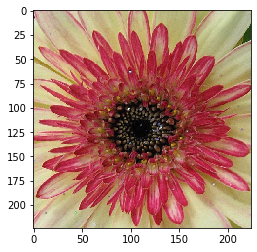

In [16]:
# Recommend Images
test_image_path = test_data_dir + "/" + os.listdir(test_data_dir)[1]
img = image.load_img(test_image_path, target_size = (224, 224))
plt.imshow(img)

# Test Recommender
model = recommender()
test_image_features = get_deep_features(test_image_path, model, (224, 224))


In [17]:
recommended_images = knn_model.kneighbors([test_image_features], NEIGHBOR_COUNT, return_distance=True)
indexes, distances = recommended_images[1][0], recommended_images[0][0]
print(indexes)
print(distances)

[ 19  60 244 150  89]
[61.85648711 70.83509764 72.65246966 76.58431517 76.92499387]


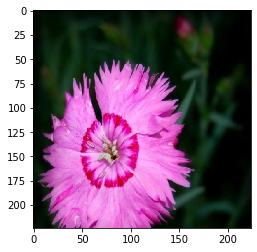

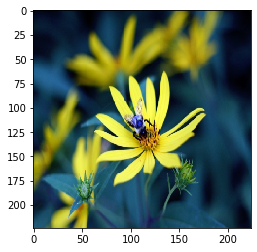

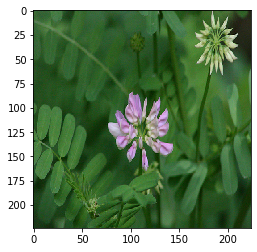

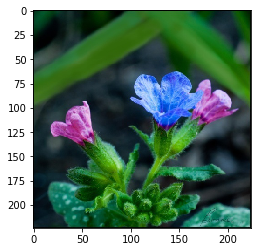

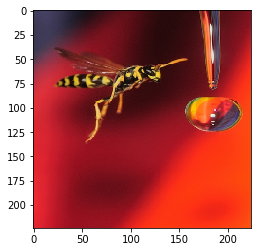

In [18]:
for i in indexes:
    image_path = train_data_dir + "/" + x[i][0] + ".jpg"
    img = image.load_img(image_path, target_size = (224, 224))
    plt.figure()
    plt.imshow(img)

In [13]:
# Classifier
classifier_deep_features = generate_feature_list("classifier")

/Users/flock/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [25]:
# Test Classifier
model = classifier()
ctest_image_features = get_deep_features(test_image_path, model, (300, 300))
print(ctest_image_features.shape)

# Classify Images
kmeans = KMeans(n_clusters=2, random_state=0).fit(classifier_deep_features["features"])
c = kmeans.cluster_centers_

/Users/flock/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


(10,)


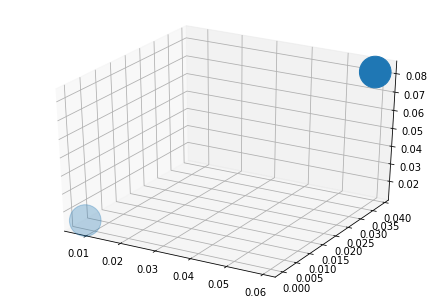

In [26]:
fig = plt.figure()
axs = Axes3D(fig)
axs.scatter(c[:, 0], c[:, 1], c[:, 2], s=1000)

In [21]:
# test_image_path = test_data_dir + "/" + os.listdir(test_data_dir)[1]
# img = image.load_img(test_image_path, target_size = (300, 300))
# img_arr = image.img_to_array(img)
# img_arr = np.expand_dims(img_arr, axis=0)
# img_arr = preprocess_input(img_arr)

# x = classifier_model.predict(img_arr)

# kmeans.predict([test_image_features])
# print(x.shape)

In [27]:
print(CLASSES[kmeans.predict([ctest_image_features])[0]])

non_food
